# Классификация токсичных комментариев с использованием BERT

Интернет-магазин **«Викишоп»** запускает новый сервис: пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают правки и комментируют изменения других пользователей.  

Для поддержания качества контента магазину необходим инструмент, который автоматически **выявляет токсичные комментарии** и отправляет их на модерацию. Это поможет:

- Снизить количество негативного контента.
- Поддерживать дружелюбную атмосферу в сообществе.
- Сократить нагрузку на модераторов.


Цель проекта: **построить модель, способную классифицировать комментарии на позитивные и негативные**, используя имеющийся датасет с разметкой о токсичности правок. Метрика качества — **F1 ≥ 0.75**.


**Инструкция по проекту**

Решение задачи можно реализовать двумя способами:

1. **С BERT**  
   - Выполнить проект локально (ограничение 4 ГБ оперативной памяти в Jupyter-тетрадке тренажёра недостаточно для BERT).
   - В первой ячейке тетрадки указать заголовок с упоминанием BERT.

2. **Без BERT**  
   - Можно работать локально или в тренажёре.
   - Использовать классические модели машинного обучения (Logistic Regression, Random Forest, LightGBM и др.).

Алгоритм решения:

1. Загрузка и подготовка данных.
2. Обучение различных моделей.
3. Сравнение результатов и выбор лучшей модели.
4. Выводы и рекомендации.

**Описание данных**

- Файл данных: `/datasets/toxic_comments.csv`
- Столбцы:
  - `text` — текст комментария
  - `toxic` — целевой признак (0 — позитивный, 1 — токсичный)

## Импорты

In [1]:
%matplotlib inline

# Работа с файлами в Google Colab
from google.colab import drive, files

# Стандартные библиотеки
import os
import re
import gc
from collections import Counter
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# NLP и токенизация
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import (
    BertTokenizer,
    AutoTokenizer,
    BertForSequenceClassification,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification
)

# ML, метрики и препроцессинг
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score
)

# PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast
from torch.cuda.amp import GradScaler

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_LENGTH = 512
MAX_FEATURES = 5000
BATCH_SIZE = 24
EPOCHS = 2
LEARNING_RATE = 2e-5
NUM_WORKERS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = "/kaggle/working/minilm_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Фиксация случайности
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

2025-09-12 23:12:34.183724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757718754.563695      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757718754.673461      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Загрузка и осмотр данных

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
try:
    df = pd.read_csv('notebooks/toxic_comments.csv')
    print('загружено локально')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    print('загружено удаленно')

загружено удаленно



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Первые 5 строк датасета:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Статистики датасета:


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000



Пропуски в данных:
Unnamed: 0    0
text          0
toxic         0
dtype: int64

Количество дубликатов:
0


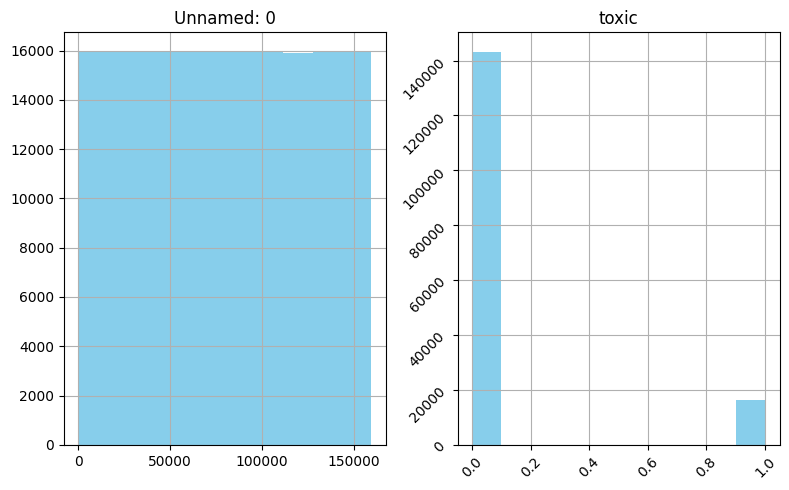

In [5]:
def check_df(df):
    print("\nИнформация о датасете:")
    display(df.info())
    print("Первые 5 строк датасета:")
    display(df.head())
    print("Статистики датасета:")
    display(df.describe())
    print("\nПропуски в данных:")
    print(df.isnull().sum())
    print("\nКоличество дубликатов:")
    print(df.duplicated().sum())

    df.hist(figsize=(8,5), color='skyblue')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

    print()

check_df(df)

In [6]:
# анализ длины текстов
df['text_length'] = df['text'].apply(len)
print("\nСтатистика длины текстов:")
print(df['text_length'].describe())


Статистика длины текстов:
count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


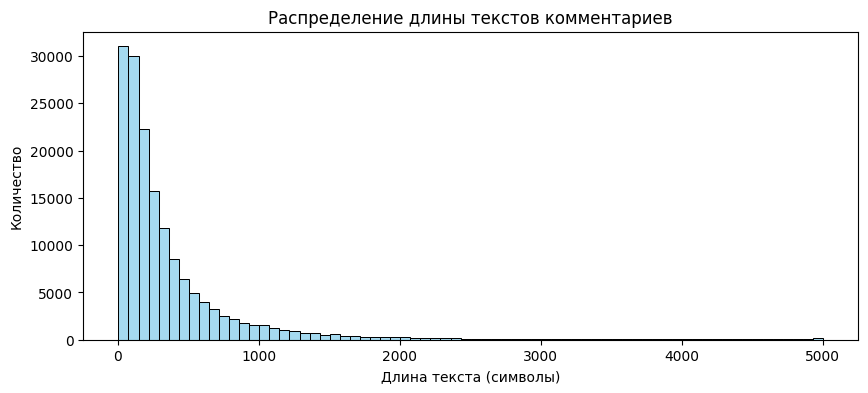

In [7]:
# визуализация распределения длины текстов
plt.figure(figsize=(10, 4))
sns.histplot(df['text_length'], bins=70, color='skyblue')
plt.title('Распределение длины текстов комментариев')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.show()

**Выводы по загрузке и анализу данных**
- Датасет содержит 159292 строки, столбцы: `text`, `toxic`.
- Столбец `Unnamed: 0` удалю как избыточный.
- Пропуски и дубликаты отсутствуют.
- Распределение классов: ~90% нетоксичных, ~10% токсичных (дисбаланс).
- Для просмотра длины текста был создан столбец `text_length`.
- Длина текстов: средняя ~393 символа, медиана ~205, максимум 5000 (явно выброс, нужно проверить) (BERT принимает до 512 токенов, нужно будет что-то делать с длинными текстами).
- **Следующий шаг**: Исследовательский анализ данных

## EDA + предобработка

Для начала удалю избыточный столбец

In [8]:
df = df.drop(columns=['Unnamed: 0'])
df.shape, df.columns

((159292, 3), Index(['text', 'toxic', 'text_length'], dtype='object'))

In [9]:
# повторно проверим распределение классов
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

### Анализ длины текстов

In [10]:
df['text_length'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

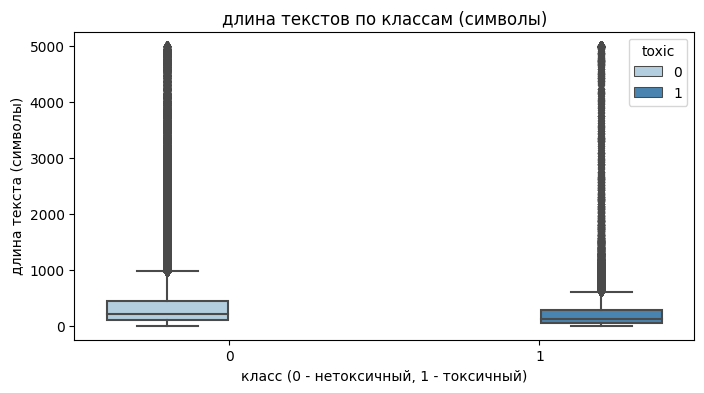

In [11]:
# boxplot длины по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y=df['text'].str.len(), hue='toxic', data=df, palette='Blues')
plt.title('длина текстов по классам (символы)')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (символы)')
plt.show()

в данных достаточно много длинных комментариев

In [12]:
df.query('text_length > 500').count()

text           33851
toxic          33851
text_length    33851
dtype: int64

комментов длиннее 500 символов почти пятая часть от всех данных

In [13]:
def get_top_words_and_ngrams(texts, top_n=30, ngram_range=(1, 1)):
    # Получение топ-слов
    if ngram_range == (1, 1):
        vec = CountVectorizer(lowercase=True, stop_words='english')
    else:
        vec = CountVectorizer(ngram_range=ngram_range, lowercase=True, stop_words='english')

    bag = vec.fit_transform(texts)
    sums = bag.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vec.vocabulary_.items()]

    top_words = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]

    return top_words

In [14]:
toxic_texts = df[df['toxic'] == 1]['text']
non_toxic_texts = df[df['toxic'] == 0]['text']

print("\nТоп-30 слов в токсичных комментариях:")
get_top_words_and_ngrams(toxic_texts)


Топ-30 слов в токсичных комментариях:


[('fuck', 9988),
 ('wikipedia', 3919),
 ('like', 3798),
 ('shit', 3688),
 ('fucking', 3320),
 ('nigger', 3306),
 ('suck', 3245),
 ('ass', 3001),
 ('don', 2840),
 ('just', 2738),
 ('hate', 2655),
 ('page', 2368),
 ('know', 2364),
 ('gay', 2262),
 ('die', 2141),
 ('people', 2057),
 ('faggot', 2025),
 ('fat', 1981),
 ('moron', 1886),
 ('bitch', 1834),
 ('hi', 1712),
 ('cunt', 1570),
 ('article', 1569),
 ('talk', 1539),
 ('stop', 1509),
 ('stupid', 1488),
 ('wiki', 1478),
 ('sucks', 1447),
 ('user', 1413),
 ('think', 1397)]

В данных очень много бесполезных слов, например, артиклей, местоимений. Также слова сами по себе не очень информативны, посмотрим n-граммы и долю капса (это признак токсичности обычно).

In [15]:
# Топ-30 биграмм в токсичных комментариях
print("\nТоп-30 биграмм в токсичных комментариях:")
display(get_top_words_and_ngrams(toxic_texts, ngram_range=(2, 2)))

# Топ-30 триграмм в токсичных комментариях
print("\nТоп-30 триграмм в токсичных комментариях:")
get_top_words_and_ngrams(toxic_texts, ngram_range=(3, 3))


Топ-30 биграмм в токсичных комментариях:


[('fuck fuck', 2959),
 ('nigger nigger', 2149),
 ('hate hate', 1570),
 ('moron hi', 1474),
 ('hi moron', 1472),
 ('pig pig', 1250),
 ('jew fat', 1234),
 ('fat jew', 1226),
 ('shit shit', 1149),
 ('suck suck', 1136),
 ('ass ass', 1127),
 ('bark bark', 999),
 ('wanker wanker', 963),
 ('bullshit bullshit', 833),
 ('balls balls', 833),
 ('nipple nipple', 763),
 ('faggot faggot', 755),
 ('talk page', 737),
 ('die die', 643),
 ('dickhead dickhead', 625),
 ('die fag', 625),
 ('fag die', 624),
 ('faggots faggots', 624),
 ('fucksex fucksex', 623),
 ('fuck yourselfgo', 621),
 ('yourselfgo fuck', 621),
 ('aids aids', 592),
 ('freedom freedom', 572),
 ('super gay', 501),
 ('gay super', 499)]


Топ-30 триграмм в токсичных комментариях:


[('fuck fuck fuck', 2825),
 ('nigger nigger nigger', 2139),
 ('hate hate hate', 1547),
 ('hi moron hi', 1468),
 ('moron hi moron', 1466),
 ('pig pig pig', 1248),
 ('fat jew fat', 1226),
 ('jew fat jew', 1224),
 ('ass ass ass', 1124),
 ('suck suck suck', 1116),
 ('shit shit shit', 1107),
 ('bark bark bark', 998),
 ('wanker wanker wanker', 960),
 ('balls balls balls', 831),
 ('bullshit bullshit bullshit', 828),
 ('nipple nipple nipple', 761),
 ('faggot faggot faggot', 749),
 ('die fag die', 624),
 ('fag die fag', 624),
 ('faggots faggots faggots', 623),
 ('fucksex fucksex fucksex', 622),
 ('fuck yourselfgo fuck', 621),
 ('yourselfgo fuck yourselfgo', 619),
 ('dickhead dickhead dickhead', 618),
 ('freedom freedom freedom', 570),
 ('die die die', 541),
 ('super gay super', 499),
 ('gay super gay', 499),
 ('buttsecks buttsecks buttsecks', 495),
 ('mothjer fucker cocksucker', 489)]

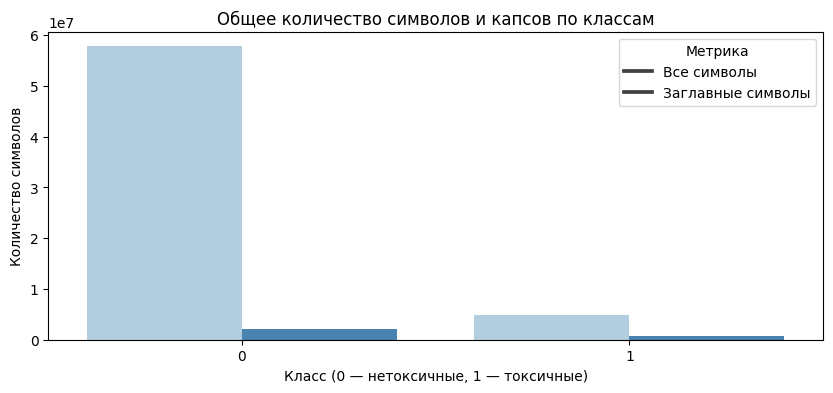

,toxic,metric,count
0,0,total_chars,57808611
1,1,total_chars,4903264
2,0,caps_chars,2035255
3,1,caps_chars,696383


In [16]:
# считаем количество символов и капсов по классам
df['total_chars'] = df['text'].str.len()
df['caps_chars'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

agg = df.groupby('toxic')[['total_chars', 'caps_chars']].sum().reset_index()

# визуализация
agg_melted = agg.melt(id_vars='toxic', value_vars=['total_chars', 'caps_chars'],
                      var_name='metric', value_name='count')

plt.figure(figsize=(10,4))
sns.barplot(x='toxic', y='count', hue='metric', data=agg_melted, palette='Blues')
plt.title('Общее количество символов и капсов по классам')
plt.xlabel('Класс (0 — нетоксичные, 1 — токсичные)')
plt.ylabel('Количество символов')
plt.legend(title='Метрика', labels=['Все символы', 'Заглавные символы'])
plt.show()
agg_melted

- В биграммах и триграммах очень много слов повторяются, нужно проверить, почему.
- Отношение капслоковых слов к общему количеству не очень большое, можно все слова привести в нижний регистр.

посмотрим, сколько из необработанных текстов сможет принять берт

### Токенизация комментариев

In [17]:
# анализ длины в токенах
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lengths = []
for text in tqdm(df['text'], desc="токенизация"):
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    token_lengths.append(len(tokens))

df['text_token_length'] = token_lengths
print("\nстатистика длины текстов (токены):")
print(df['text_token_length'].describe())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

токенизация:   0%|          | 0/159292 [00:00<?, ?it/s]


статистика длины текстов (токены):
count    159292.000000
mean         88.134307
std         102.500119
min           4.000000
25%          26.000000
50%          52.000000
75%         104.000000
max         512.000000
Name: text_token_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


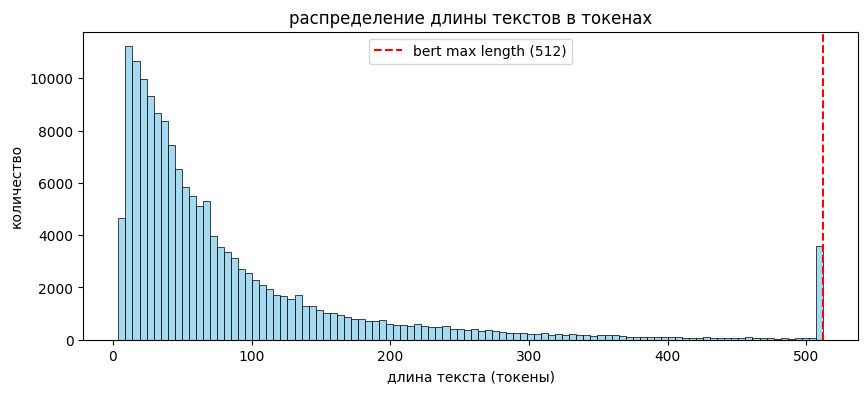

In [18]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['text_token_length'], bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()

токенайзер просто обрезал большинство текстов до 512 токенов. поработаем с качеством текстов.

### Обработка текстов

- загрузим стопслова
- удалим пунктуацию
- удалим все не-ascii символы
- приведем все тексты в нижний регистр

In [19]:
# загружаем stopwords
stop_words = set(stopwords.words('english'))

# проверяем не-ascii перед удалением
non_ascii = df[df['text'].str.contains('[^\x00-\x7F]', regex=True, na=False)]
print(f"тексты с не-ascii символами: {len(non_ascii)} ({len(non_ascii)/len(df)*100:.2f}%)")

# проверяем caps ratio (доля заглавных букв) перед lowercase
def calc_caps_ratio(text):
    if not text:
        return 0
    total_chars = len(text)
    caps_chars = sum(1 for c in text if c.isupper())
    return caps_chars / total_chars if total_chars > 0 else 0

df['caps_ratio'] = df['text'].apply(calc_caps_ratio)
print("\nстатистика caps ratio по классам:")
display(df.groupby('toxic')['caps_ratio'].describe())

# функция очистки текста
def clean_text(text):
    # переводим в нижний регистр
    text = text.lower()
    # удаляем не-ascii
    text = re.sub(r'[^\x00-\x7F]', '', text)
    # удаляем пунктуацию
    text = re.sub(r'[^\w\s]', '', text)
    # удаляем stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# применяем очистку
df['clean_text'] = df['text'].apply(clean_text)

тексты с не-ascii символами: 17178 (10.78%)

статистика caps ratio по классам:


,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143106.0,0.044905,0.065405,0.0,0.020833,0.031579,0.047619,0.962963
1,16186.0,0.110978,0.207466,0.0,0.019380,0.034682,0.068042,0.998189


In [20]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']

print("\nТоп-30 слов в токсичных комментариях:")
get_top_words_and_ngrams(toxic_texts)


Топ-30 слов в токсичных комментариях:


[('fuck', 8662),
 ('dont', 3877),
 ('like', 3759),
 ('shit', 3647),
 ('wikipedia', 3473),
 ('nigger', 3295),
 ('fucking', 3222),
 ('suck', 3044),
 ('ass', 2652),
 ('hate', 2636),
 ('know', 2341),
 ('page', 2328),
 ('gay', 2245),
 ('im', 2223),
 ('die', 2136),
 ('fat', 1978),
 ('people', 1974),
 ('faggot', 1962),
 ('youre', 1925),
 ('moron', 1885),
 ('hi', 1709),
 ('cunt', 1555),
 ('article', 1535),
 ('stop', 1485),
 ('stupid', 1473),
 ('sucks', 1445),
 ('bitch', 1432),
 ('think', 1392),
 ('talk', 1380),
 ('jew', 1349)]

In [21]:
# проверяем пустые тексты после очистки
empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после очистки: {len(empty_clean)}")


пустые тексты после очистки: 21


In [22]:
df.head(20)

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text
0,Explanation\nWhy the edits made under my usern...,0,264,264,17,68,0.064394,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,112,112,8,35,0.071429,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,233,233,4,54,0.017167,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,622,11,144,0.017685,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,67,67,2,21,0.029851,sir hero chance remember page thats
5,"""\n\nCongratulations from me as well, use the ...",0,65,65,1,17,0.015385,congratulations well use tools well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,44,44,37,12,0.840909,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,115,115,4,31,0.034783,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,472,472,7,119,0.014831,sorry word nonsense offensive anyway im intend...
9,alignment on this subject and which are contra...,0,70,70,2,17,0.028571,alignment subject contrary dulithgow


In [23]:
df['clean_text_length'] = df['clean_text'].apply(len)
print("\nСтатистика длины текстов:")
df['clean_text_length'].describe()


Статистика длины текстов:


count    159292.000000
mean        254.377897
std         395.470121
min           0.000000
25%          60.000000
50%         131.000000
75%         278.000000
max        5000.000000
Name: clean_text_length, dtype: float64

In [24]:
df.query('clean_text_length >= 1500')

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length
10,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,2875,2875,53,512,0.018435,fair use rationale imagewonjujpg thanks upload...,1829
50,"""\n\nBI, you said you wanted to talk\n\nAt the...",0,3150,3150,78,512,0.024762,bi said wanted talk bottom lead section writte...,2272
81,"""\n\nIs it scientific to attribute an event A,...",0,2749,2749,83,512,0.030193,scientific attribute event cause b cause b del...,1716
126,"Ahh, Hello Witzeman \n\n203.92.84.161 \nSymbo...",0,4364,4364,271,512,0.062099,ahh hello witzeman 2039284161 symbols characte...,2070
160,"""== Attributing and classifying of personaliti...",0,3958,3958,121,512,0.030571,attributing classifying personalities invitati...,2930
...,...,...,...,...,...,...,...,...,...
159127,Heres the talkpage discussion - that Jehocman ...,0,2647,2647,129,512,0.048734,heres talkpage discussion jehocman blocked hi ...,1599
159138,"""\n\n News suppressed on Wikipedia http://rexc...",0,4833,4833,168,512,0.034761,news suppressed wikipedia httprexcurrynetwikip...,3415
159164,"""\nI understand you, but you also should under...",0,2262,2262,123,512,0.054377,understand also understand shouldnt revert wor...,1505
159180,"""\n\n Evidence Redux \n\nI'll be frank. The b...",0,3508,3508,66,512,0.018814,evidence redux ill frank blocking came bit lat...,2194


Комментарии состоящие из одного или нескольких повторяющихся слов, чередования слов, например, know fggt know fggt, и длиннее 1000-1500 символов, думаю, можно отнести к спаму и избавиться от них или обработать, например, сжать подряд идущие слова и устранить чередования.

### Обработка спама

In [25]:
# функция для подсчёта уникальности слов
def uniqueness_score(text):
    if not isinstance(text, str) or not text:
        return 1.0
    words = text.split()
    return len(set(words)) / len(words) if words else 1.0

# доработанная функция collapse_repeats
def collapse_repeats(text, max_repeats=5):
    if not isinstance(text, str) or not text:
        return ''

    # разбиваем на слова
    words = text.split()
    result = []
    seen_pairs = {}  # словарь для отслеживания чередующихся пар (A B A B)

    i = 0
    while i < len(words):
        # проверяем пары слов
        if i + 1 < len(words):
            pair = (words[i].lower(), words[i + 1].lower())
            if pair in seen_pairs:
                seen_pairs[pair] += 1
                if seen_pairs[pair] > max_repeats:
                    i += 2  # пропускаем повторяющуюся пару
                    continue
            else:
                seen_pairs[pair] = 1
            result.extend([words[i], words[i + 1]])
            i += 2
        else:
            result.append(words[i])
            i += 1

    return ' '.join(result)

In [26]:
df['text_length'] = df['clean_text'].str.len()
df['uniqueness'] = df['clean_text'].apply(uniqueness_score)
potential_spam = df[df['uniqueness'] < 0.5]
print(f"\nпотенциальный спам (уникальность <50%): {len(potential_spam)} ({len(potential_spam)/len(df)*100:.2f}%)")
if len(potential_spam) > 0:
    print("\nраспределение классов в потенциальном спаме:")
    print(potential_spam['toxic'].value_counts(normalize=True))
    print("\nпримеры потенциального спама:")
    print(potential_spam[['text', 'clean_text']].head(5))


потенциальный спам (уникальность <50%): 761 (0.48%)

распределение классов в потенциальном спаме:
toxic
1    0.516426
0    0.483574
Name: proportion, dtype: float64

примеры потенциального спама:
                                                   text  \
505   2010 Meet a Local - Vietnam TV Series, Factual...   
788   Other Bush articles not referenced in George W...   
1043  "\n\nOrphaned non-free image (Image:KSV Hessen...   
1303  "\nWrong licenses\nI have corrected the licens...   
1336  I AM GAY\nLove\n  \nI AM GAY\nLove\n  \nI AM G...   

                                             clean_text  
505   2010 meet local vietnam tv series factual docu...  
788   bush articles referenced george w bush none fo...  
1043  orphaned nonfree image imageksv hessen kasselp...  
1303  wrong licenses corrected licenses majority ima...  
1336                         gay love gay love gay love  


In [27]:
# применяем сжатие чередующихся повторов
df['clean_text'] = df['clean_text'].apply(lambda x: collapse_repeats(x, max_repeats=2))

In [28]:
# проверяем результат
df['clean_text_length'] = df['clean_text'].str.len()
print(f"\nстатистика длины текстов после сжатия:")
print(df['clean_text_length'].describe())
print(f"\nтексты длиннее 512 символов после сжатия: {len(df[df['clean_text_length'] > 512])} ({len(df[df['clean_text_length'] > 512])/len(df)*100:.2f}%)")

empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после сжатия: {len(empty_clean)} ({len(empty_clean)/len(df)*100:.2f}%)")
if len(empty_clean) > 0:
    print("\nраспределение классов в пустых текстах:")
    print(empty_clean['toxic'].value_counts(normalize=True))
    df = df[~df['clean_text'].str.strip().eq('')]


статистика длины текстов после сжатия:
count    159292.000000
mean        248.057122
std         371.017989
min           0.000000
25%          60.000000
50%         130.000000
75%         275.000000
max        4965.000000
Name: clean_text_length, dtype: float64

тексты длиннее 512 символов после сжатия: 18191 (11.42%)

пустые тексты после сжатия: 21 (0.01%)

распределение классов в пустых текстах:
toxic
0    0.952381
1    0.047619
Name: proportion, dtype: float64


In [29]:
df.query('clean_text_length <= 10')

,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length,uniqueness
259,Y r we doing this: Pat,0,5,22,2,9,0.090909,r pat,5,1.0
627,Seems we both have some.,0,5,24,1,8,0.041667,seems,5,1.0
807,You are \n\nso retarded.,1,8,22,1,9,0.045455,retarded,8,1.0
852,P.S. Are you a /b/tard?,1,8,23,3,15,0.130435,ps btard,8,1.0
899,I've just seen that,0,8,19,1,8,0.052632,ive seen,8,1.0
...,...,...,...,...,...,...,...,...,...,...
158791,!!! \nDOWN WITH THE USA!!!,1,3,25,14,12,0.560000,usa,3,1.0
158964,wtf \n\n your a queer,1,9,20,0,7,0.000000,wtf queer,9,1.0
159169,Yeah i no it sucks.,1,10,19,1,8,0.052632,yeah sucks,10,1.0
159193,You ignored him too,0,7,19,1,6,0.052632,ignored,7,1.0


stopwords, конечно, довольно сильно подрезал предложения, но, семантику, вроде, потеряли не слишком сильно, ключевые положительные и негативные слова, в большинстве своем, остались.
далее можно удалить строки с комментариями короче 3 символов и посчитать длины текстов в токенах с помощью токенайзера берт.

In [30]:
df = df.query('clean_text_length > 3')

проверим качество обработки спама:

In [31]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']

In [32]:
# Топ-30 слов в токсичных комментариях
print("\nТоп-30 слов в токсичных комментариях:")
print(get_top_words_and_ngrams(toxic_texts))

# Топ-30 биграмм в токсичных комментариях
print("\nТоп-30 биграмм в токсичных комментариях:")
print(get_top_words_and_ngrams(toxic_texts, ngram_range=(2, 2)))

# Топ-30 триграмм в токсичных комментариях
print("\nТоп-30 триграмм в токсичных комментариях:")
print(get_top_words_and_ngrams(toxic_texts, ngram_range=(3, 3)))


Топ-30 слов в токсичных комментариях:
[('fuck', 3329), ('dont', 3280), ('like', 3099), ('wikipedia', 2642), ('fucking', 2274), ('page', 2211), ('im', 2017), ('people', 1904), ('know', 1831), ('youre', 1671), ('shit', 1606), ('article', 1529), ('think', 1389), ('stop', 1373), ('talk', 1267), ('stupid', 1184), ('time', 1142), ('want', 1069), ('ass', 1061), ('life', 1041), ('make', 977), ('bitch', 954), ('edit', 923), ('really', 901), ('little', 891), ('block', 874), ('right', 849), ('say', 809), ('going', 802), ('good', 800)]

Топ-30 биграмм в токсичных комментариях:
[('talk page', 613), ('dont know', 321), ('piece shit', 244), ('im going', 193), ('fuck fuck', 190), ('dont care', 183), ('people like', 166), ('personal attack', 158), ('personal attacks', 155), ('dont like', 148), ('dont think', 135), ('dont want', 124), ('user page', 124), ('ha ha', 119), ('suck dick', 105), ('comment added', 96), ('im sure', 96), ('unsigned comment', 94), ('son bitch', 93), ('preceding unsigned', 92), (

совершенно неплохо. количество повторов в н-граммах очень сильно снизилось, хоть и не полностью, но какое-то количество допустимо, так как при агрессивной обработке повторов можно потерять семантику текстов.

### Токенизация чистых комментов

In [33]:
# анализ длины в токенах
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_lengths = []
for text in tqdm(df['clean_text'], desc="токенизация"):
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    token_lengths.append(len(tokens))

df['token_length'] = token_lengths
print("\nстатистика длины текстов (токены):")
print(df['token_length'].describe())

токенизация:   0%|          | 0/159239 [00:00<?, ?it/s]


статистика длины текстов (токены):
count    159239.000000
mean         46.080100
std          63.153953
min           3.000000
25%          14.000000
50%          26.000000
75%          51.000000
max         512.000000
Name: token_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


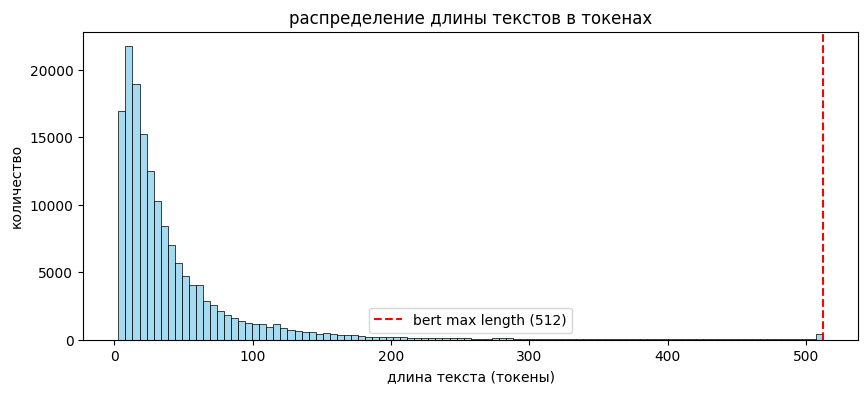

In [34]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['token_length'], bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()

обработка текстов показала себя хорошо. мы потеряли минимум данных и при этом токенайзер не просто обрезал комментарии на 512 токенах, как в необработанных текстах. почти все тексты влезли в необходимый порог. Далее посмотрим корреляции и зависимости.

### Вывод: EDA + предобработка

- Датасет содержит **159 292 комментария**, с сильным дисбалансом классов: ~90% нетоксичных и ~10% токсичных.
- Комментарии сильно различаются по длине: от нескольких символов до 5000, средняя длина после очистки — 248 символов.
- **Токсичные комментарии** характеризуются:
  - высоким содержанием ругательств и негативных слов;
  - большим количеством заглавных букв;
  - повторяющимися словами и шаблонными паттернами (спам).
- Очистка текстов включала:
  - удаление пунктуации и не-ASCII символов;
  - удаление стоп-слов;
  - приведение к нижнему регистру;
  - сжатие повторяющихся слов и чередующихся паттернов.
- После предобработки:
  - пустых текстов практически нет (0.01%);
  - большинство комментариев помещается в лимит BERT (≤512 токенов);
  - семантика и ключевые признаки токсичности сохранены.
- **Данные готовы к обучению моделей**, включая BERT и классические алгоритмы машинного обучения, с минимальным шумом и корректной структурой.

## Корреляционный анализ


корреляция Пирсона:


,caps_ratio,clean_text_length,token_length,uniqueness,toxic,text_length,total_chars,caps_chars
caps_ratio,1.000000,-0.095778,-0.086532,-0.015129,0.214987,-0.043195,-0.057872,0.310289
clean_text_length,-0.095778,1.000000,0.982545,-0.505409,-0.084531,0.943450,0.954644,0.197935
token_length,-0.086532,0.982545,1.000000,-0.509078,-0.073891,0.928889,0.942517,0.192931
uniqueness,-0.015129,-0.505409,-0.509078,1.000000,0.009347,-0.588640,-0.585243,-0.328607
toxic,0.214987,-0.084531,-0.073891,0.009347,1.000000,-0.048388,-0.051740,0.090100
text_length,-0.043195,0.943450,0.928889,-0.588640,-0.048388,1.000000,0.989913,0.403906
total_chars,-0.057872,0.954644,0.942517,-0.585243,-0.051740,0.989913,1.000000,0.370251
caps_chars,0.310289,0.197935,0.192931,-0.328607,0.090100,0.403906,0.370251,1.000000


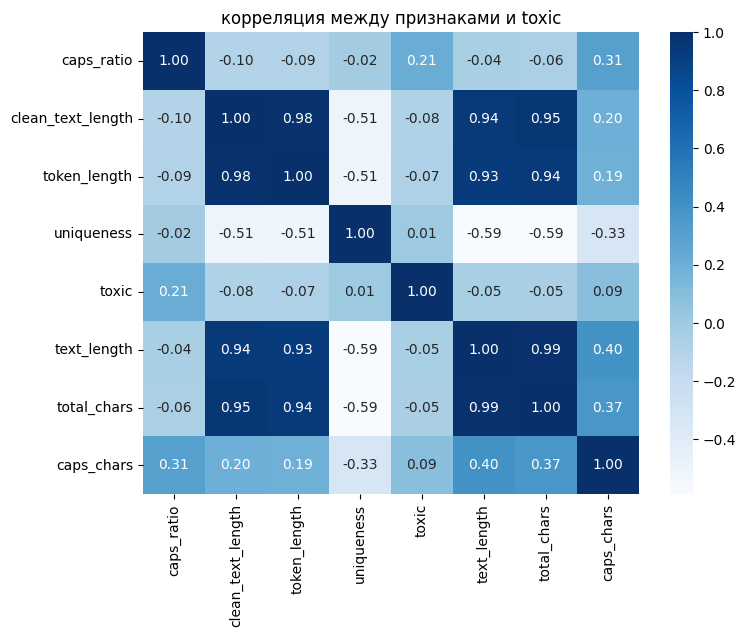

In [35]:
# корреляция между числовыми признаками и toxic
corr_matrix = df[['caps_ratio',
                  'clean_text_length',
                  'token_length',
                  'uniqueness',
                  'toxic',
                  'text_length',
                  'total_chars',
                  'caps_chars',
                  ]].corr(method='pearson')
print("\nкорреляция Пирсона:")
display(corr_matrix)

# визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('корреляция между признаками и toxic')
plt.show()

- **Корреляция Пирсона**:  
  - `caps_ratio` имеет умеренную положительную корреляцию с `toxic` (r=0.2150), что подтверждает: токсичные тексты чаще содержат заглавные буквы.  
  - `clean_text_length` и `token_length` слабо отрицательно коррелируют с `toxic` (r=-0.0845 и r=-0.0739), указывая, что токсичные тексты слегка короче.  
  - `uniqueness` имеет почти нулевую корреляцию с `toxic` (r=0.0093), то есть уникальность слов не влияет на токсичность.  
  - Высокая корреляция между `clean_text_length` и `token_length` (r=0.9825) ожидаема, так как они измеряют длину текста.


точечная биссериальная корреляция для caps_ratio:
корреляция: 0.2150, p-value: 0.0000

точечная биссериальная корреляция для clean_text_length:
корреляция: -0.0845, p-value: 0.0000

точечная биссериальная корреляция для token_length:
корреляция: -0.0739, p-value: 0.0000

точечная биссериальная корреляция для uniqueness:
корреляция: 0.0093, p-value: 0.0002


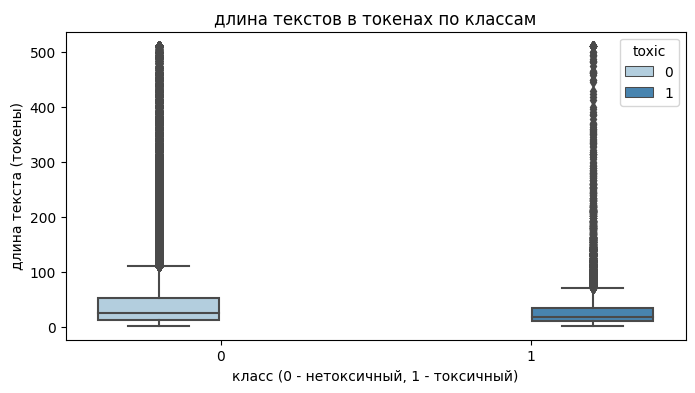

In [36]:
# точечная биссериальная корреляция для toxic (бинарный)
for feature in ['caps_ratio', 'clean_text_length', 'token_length', 'uniqueness']:
    corr, p_value = pointbiserialr(df[feature], df['toxic'])
    print(f"\nточечная биссериальная корреляция для {feature}:")
    print(f"корреляция: {corr:.4f}, p-value: {p_value:.4f}")

# boxplot для token_length по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y='token_length', hue='toxic', data=df, palette='Blues')
plt.title('длина текстов в токенах по классам')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (токены)')
plt.show()

- **Точечная биссериальная корреляция**:  
  - Подтверждает выводы Пирсона: `caps_ratio` (r=0.2150, p=0.0000) хорошо связан с токсичностью, `clean_text_length` и `token_length` имеют слабую связь, `uniqueness` почти не влияет (p=0.0002, но r=0.0093).
- **Boxplot `token_length`**:  
  - Токсичные тексты имеют меньшую медианную длину (около 40 токенов) по сравнению с нетоксичными (около 50 токенов), но разница небольшая.

In [37]:
# анализ частоты токсичных слов
toxic_words = ['fuck', 'shit', 'nigger', 'ass', 'faggot', 'bitch', 'cunt']
def count_toxic_words(text):
    if not isinstance(text, str):
        return 0
    return sum(text.lower().count(word) for word in toxic_words)

df['toxic_word_count'] = df['clean_text'].apply(count_toxic_words)
print("\nстатистика частоты токсичных слов по классам:")
df.groupby('toxic')['toxic_word_count'].describe()


статистика частоты токсичных слов по классам:


,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,143058.0,0.154252,0.600155,0.0,0.0,0.0,0.0,28.0
1,16181.0,1.060874,9.987325,0.0,0.0,0.0,1.0,1238.0


- **Частота токсичных слов**:  
  - Токсичные тексты содержат значительно больше токсичных слов (mean=1.06, max=1238) по сравнению с нетоксичными (mean=0.15, max=28).  
  - Признак `toxic_word_count` важен для модели, так как явно различает классы.

### Вывод: Корреляционный анализ

**Корреляция между числовыми признаками и токсичностью**

- **caps_ratio** имеет умеренную положительную корреляцию с toxic (r ≈ 0.215), подтверждая, что токсичные комментарии чаще содержат заглавные буквы.
- **clean_text_length** и **token_length** слабо отрицательно коррелируют с toxic (r ≈ -0.08 и -0.074), что указывает на тенденцию к немного более коротким токсичным текстам.
- **uniqueness** почти не влияет на токсичность (r ≈ 0.009), то есть разнообразие слов не определяет токсичность.
- Высокая корреляция между clean_text_length и token_length (r ≈ 0.98) ожидаема, так как оба признака отражают длину текста.

**Точечная биссериальная корреляция**
- Подтверждает выводы Пирсона:
  - **caps_ratio** — сильная связь с токсичностью.
  - **clean_text_length** и **token_length** — слабая связь.
  - **uniqueness** — практически не влияет (p-value очень малое, но корреляция близка к нулю).

**Boxplot длины текста в токенах**
- Медианная длина токенов для токсичных комментариев ≈ 40, для нетоксичных ≈ 50.
- Разница есть, но она небольшая — длина текста сама по себе не является сильным признаком токсичности.

**Частота токсичных слов**
- Токсичные тексты содержат значительно больше токсичных слов (mean ≈ 1.06, max = 1238) по сравнению с нетоксичными (mean ≈ 0.15, max = 28).
- **toxic_word_count** — явный и сильный признак для модели.

**Общий вывод**
- **Главный сигнал токсичности** в данных — это наличие токсичных слов и использование заглавных букв.
- Длина текста и уникальность слов имеют слабое влияние, но могут быть полезны в сочетании с другими признаками.
- Для моделей классификации текстов стоит учитывать **caps_ratio** и **toxic_word_count** как важные числовые признаки, а также использовать текстовые признаки для BERT или других трансформеров.

## Подготовка к обучению

In [38]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 159239 entries, 0 to 159291
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   text               159239 non-null  object 
 1   toxic              159239 non-null  int64  
 2   text_length        159239 non-null  int64  
 3   total_chars        159239 non-null  int64  
 4   caps_chars         159239 non-null  int64  
 5   text_token_length  159239 non-null  int64  
 6   caps_ratio         159239 non-null  float64
 7   clean_text         159239 non-null  object 
 8   clean_text_length  159239 non-null  int64  
 9   uniqueness         159239 non-null  float64
 10  token_length       159239 non-null  int64  
 11  toxic_word_count   159239 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 15.8+ MB
None


,text,toxic,text_length,total_chars,caps_chars,text_token_length,caps_ratio,clean_text,clean_text_length,uniqueness,token_length,toxic_word_count
0,Explanation\nWhy the edits made under my usern...,0,186,264,17,68,0.064394,explanation edits made username hardcore metal...,186,1.000000,43,0
1,D'aww! He matches this background colour I'm s...,0,86,112,8,35,0.071429,daww matches background colour im seemingly st...,86,1.000000,19,0
2,"Hey man, I'm really not trying to edit war. It...",0,144,233,4,54,0.017167,hey man im really trying edit war guy constant...,144,1.000000,26,0
3,"""\nMore\nI can't make any real suggestions on ...",0,379,622,11,144,0.017685,cant make real suggestions improvement wondere...,379,0.918367,66,0
4,"You, sir, are my hero. Any chance you remember...",0,35,67,2,21,0.029851,sir hero chance remember page thats,35,1.000000,9,0


**text**  
Не нужен, так как clean_text — очищенная версия, используемая для TF-IDF и BERT.  
**Действие:** Удалить.

**toxic**  
Целевой признак, обязателен для всех моделей.  
**Действие:** Оставить.

**text_length**  
Длина оригинального текста в символах. Корреляция с toxic низкая (r=-0.07).  
**Рекомендация:** Удалить.

**total_chars**  
Используется для вычисления caps_ratio, но сам по себе не нужен.  
**Рекомендация:** Удалить.

**caps_chars**  
Используется для вычисления caps_ratio. Сам по себе не нужен, так как caps_ratio информативнее.  
**Рекомендация:** Удалить.

**text_token_length**  
Длина оригинального текста в токенах, не используется после создания clean_text и token_length.  
**Рекомендация:** Удалить.

**caps_ratio**  
Значимый признак (r=0.2150 с toxic), полезен для baseline.  
**Рекомендация:** Оставить.

**clean_text**  
Основной столбец для TF-IDF (baseline) и токенизации BERT.  
**Рекомендация:** Оставить.

**clean_text_length**  
Длина очищенного текста, высокая корреляция с token_length (r=0.9825), слабая с toxic (r=-0.0845). Может быть полезна для baseline, но избыточна для BERT.  
**Рекомендация:** Оставить для baseline, удалить перед BERT.

**uniqueness**  
Очень слабая корреляция с toxic (r=0.0093), неинформативна.  
**Рекомендация:** Удалить.

**token_length**  
Длина в токенах BERT, полезна для анализа, но не для обучения (BERT использует input_ids). Слабая корреляция с toxic (r=-0.0739). Сильная корреляция с clean_text_length.
**Рекомендация:** Удалить.

**toxic_word_count**  
Значимый признак (mean=1.06 в токсичных vs. 0.15 в нетоксичных), полезен для baseline.  
**Рекомендация:** Оставить.

In [39]:
# удаление ненужных столбцов
columns_to_drop = ['text', 'text_length', 'total_chars', 'caps_chars', 'text_token_length', 'uniqueness', 'token_length']
df = df.drop(columns=columns_to_drop)
df.columns.tolist()

['toxic', 'caps_ratio', 'clean_text', 'clean_text_length', 'toxic_word_count']

### Cплит

In [40]:
# разделение на train/test
X = df[['clean_text', 'caps_ratio', 'clean_text_length', 'toxic_word_count']]
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((127391, 4), (127391,), (31848, 4), (31848,))

In [42]:
# проверка распределения классов
print("\nраспределение классов в train:")
print(y_train.value_counts(normalize=True))
print("\nраспределение классов в test:")
print(y_test.value_counts(normalize=True))


распределение классов в train:
toxic
0    0.898384
1    0.101616
Name: proportion, dtype: float64

распределение классов в test:
toxic
0    0.898392
1    0.101608
Name: proportion, dtype: float64


### TF-IDF векторизация для baseline

In [43]:
# tf-idf векторизация
tfidf = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train['clean_text'])
X_test_tfidf = tfidf.transform(X_test['clean_text'])

### Масштабирование числовых признаков

In [44]:
# масштабирование числовых признаков
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[['caps_ratio', 'clean_text_length', 'toxic_word_count']])
X_test_numeric = scaler.transform(X_test[['caps_ratio', 'clean_text_length', 'toxic_word_count']])

In [45]:
# объединение tf-idf и числовых признаков
X_train_features = np.hstack([X_train_tfidf.toarray(), X_train_numeric])
X_test_features = np.hstack([X_test_tfidf.toarray(), X_test_numeric])

### Вывод: Подготовка данных к baseline

**Очищение и выбор признаков**  
Удалены избыточные и неинформативные колонки: `text`, `text_length`, `total_chars`, `caps_chars`, `text_token_length`, `token_length`, `uniqueness`.  
Оставлены информативные признаки: `toxic` (цель), `caps_ratio` (умеренная корреляция с токсичностью), `clean_text` (основной текст для TF-IDF и BERT), `clean_text_length` (длина текста, полезна для baseline), `toxic_word_count` (количество токсичных слов, сильный сигнал).

**Разделение на тренировочную и тестовую выборки**  
Train: 127,391 строк, Test: 31,848 строк.  
Сохраняется баланс классов: токсичные ≈ 10%, нетоксичные ≈ 90% через stratify.

**TF-IDF векторизация (для baseline)**  
`clean_text` преобразован в TF-IDF матрицу с ограничением `max_features=MAX_FEATURES` и исключением стоп-слов. Получены обучающие (`X_train_tfidf`) и тестовые (`X_test_tfidf`) матрицы.

**Масштабирование числовых признаков**  
Числовые признаки (`caps_ratio`, `clean_text_length`, `toxic_word_count`) стандартизированы с помощью `StandardScaler`. Результат: `X_train_numeric`, `X_test_numeric`.

**Объединение признаков**  
TF-IDF и числовые признаки объединены в финальные обучающие и тестовые матрицы: `X_train_features` и `X_test_features`.

**Вывод**  
Данные полностью подготовлены для обучения моделей на TF-IDF + числовых признаках (baseline). Для BERT используется только `clean_text` с токенизацией. Признаки, явно связанные с токсичностью (`caps_ratio`, `toxic_word_count`), сохранены для повышения информативности модели.


## Baseline

В качестве бейщлайн модели я рещил обучить логистическую регрессию с tf-idf по нескольким причинам:

1. во-первых, чтобы сравнить качество моделей на tf-idf с результатами на bert
2. во-вторых, чтобы задать нижнюю границу метрики.

In [46]:
# обучение логистической регрессии
lr_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_features, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [47]:
# предсказания трейн
y_pred_train = lr_model.predict(X_train_features)
y_pred_proba_train = lr_model.predict_proba(X_train_features)[:, 1]

# предсказания тест
y_pred = lr_model.predict(X_test_features)
y_pred_proba = lr_model.predict_proba(X_test_features)[:, 1]

In [48]:
# метрики
print("\nрезультаты baseline на трейн и тест выборках (логистическая регрессия):")
print(f"f1-score TRAIN (weighted): {f1_score(y_train, y_pred_train, average='weighted'):.4f}")
print(f"f1-score TEST (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print()
print(f"roc-auc TRAIN: {roc_auc_score(y_train, y_pred_proba_train):.4f}")
print(f"roc-auc TEST: {roc_auc_score(y_test, y_pred_proba):.4f}")
print()
print(f"precision TRAIN (toxic): {precision_score(y_train, y_pred_train):.4f}")
print(f"precision TEST (toxic): {precision_score(y_test, y_pred):.4f}")
print()
print(f"recall TRAIN (toxic): {recall_score(y_train, y_pred_train):.4f}")
print(f"recall TEST (toxic): {recall_score(y_test, y_pred):.4f}")


результаты baseline на трейн и тест выборках (логистическая регрессия):
f1-score TRAIN (weighted): 0.9385
f1-score TEST (weighted): 0.9311

roc-auc TRAIN: 0.9781
roc-auc TEST: 0.9610

precision TRAIN (toxic): 0.6164
precision TEST (toxic): 0.5922

recall TRAIN (toxic): 0.9039
recall TEST (toxic): 0.8514


Результаты очень хорошие. На тестовых данных метрика незначительно ниже, чем на тренировочных. Это говорит об отсутсвии переобучения.

Попробуем BERT с fine-tuning. Если результаты будут неудовлетворительными, будем использовать BERT без fine-tuning для создания эмбеддингов, а после обучим на них модель градиентного бустинга.

### Вывод: Baseline модель - Логистическая регрессия на TF-IDF

**Цель выбора**  
- Сравнить качество моделей на TF-IDF с результатами на BERT.  
- Определить нижнюю границу метрики (baseline).

**Обучение**  
Логистическая регрессия обучена с параметрами: `class_weight='balanced'`, `max_iter=1000`, `random_state=42`.

**Результаты на тренировочной выборке**  
- F1-score (weighted): 0.9385  
- ROC-AUC: 0.9781  
- Precision (toxic): 0.6164  
- Recall (toxic): 0.9039  

**Результаты на тестовой выборке**  
- F1-score (weighted): 0.9311  
- ROC-AUC: 0.9610  
- Precision (toxic): 0.5922  
- Recall (toxic): 0.8514  

**Выводы**  
- Модель показывает высокую эффективность, метрики на тесте лишь слегка ниже, чем на трейне — переобучения нет.  
- Признаки `caps_ratio` и `toxic_word_count` внесли значимый вклад в качество модели.  
- Этот результат служит надежной базовой линией для дальнейшего сравнения с моделями на BERT.  

**Дальнейшие шаги**  
- Обучение BERT с fine-tuning.  
- Если fine-tuning окажется недостаточно эффективным, использовать BERT для генерации эмбеддингов и обучить на них градиентный бустинг.


## Подготовка данных для BERT

In [49]:
del token_lengths
del tokens
del tokenizer
del stop_words
del y_pred_train
del y_pred_proba_train
del lr_model
del tfidf
del X_train_tfidf
del X_test_tfidf
del X_train_features
del X_test_features
gc.collect()

26029

In [50]:
df = df.copy()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159239 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   toxic              159239 non-null  int64  
 1   caps_ratio         159239 non-null  float64
 2   clean_text         159239 non-null  object 
 3   clean_text_length  159239 non-null  int64  
 4   toxic_word_count   159239 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 7.3+ MB


In [52]:
# удаление ненужных столбцов
columns_to_keep = ['clean_text', 'toxic']
df = df[columns_to_keep]
df.columns.tolist()

['clean_text', 'toxic']

### Сплит

In [53]:
# разделение на train/test
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [54]:
train_df.shape, test_df.shape

((127391, 2), (31848, 2))

In [55]:
# проверка распределения классов
print("\nраспределение классов в train:")
print(train_df['toxic'].value_counts(normalize=True))
print("\nраспределение классов в test:")
print(test_df['toxic'].value_counts(normalize=True))


распределение классов в train:
toxic
0    0.898384
1    0.101616
Name: proportion, dtype: float64

распределение классов в test:
toxic
0    0.898392
1    0.101608
Name: proportion, dtype: float64


In [56]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

def prepare_data(df, max_length=MAX_LENGTH):
    input_ids, attention_masks = [], []
    labels = df['toxic'].values

    for text in tqdm(df['clean_text'], desc="токенизация"):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return input_ids, attention_masks, labels

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Токенизация

In [58]:
# токенизация train и test
train_inputs, train_masks, train_labels = prepare_data(train_df)
test_inputs, test_masks, test_labels = prepare_data(test_df)

токенизация:   0%|          | 0/127391 [00:00<?, ?it/s]

токенизация:   0%|          | 0/31848 [00:00<?, ?it/s]

In [59]:
# проверка размеров
print(f"\nразмер train: {len(train_df)} строк, {train_inputs.shape}")
print(f"размер test: {len(test_df)} строк, {test_inputs.shape}")


размер train: 127391 строк, torch.Size([127391, 512])
размер test: 31848 строк, torch.Size([31848, 512])


In [60]:
# сохранение тензоров
torch.save(train_inputs, os.path.join(OUTPUT_DIR, 'train_inputs.pt'))
torch.save(train_masks, os.path.join(OUTPUT_DIR, 'train_masks.pt'))
torch.save(train_labels, os.path.join(OUTPUT_DIR, 'train_labels.pt'))
torch.save(test_inputs, os.path.join(OUTPUT_DIR, 'test_inputs.pt'))
torch.save(test_masks, os.path.join(OUTPUT_DIR, 'test_masks.pt'))
torch.save(test_labels, os.path.join(OUTPUT_DIR, 'test_labels.pt'))

### Балансировка классов

In [61]:
# настройка WeightedRandomSampler для балансировки классов
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

### Создание DataLoader

In [62]:
# создание DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

train_loader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\nсоздано: {len(train_loader)} батчей для train, {len(test_loader)} батчей для test")


создано: 5308 батчей для train, 1327 батчей для test


### Вывод: Подготовка данных для BERT

**Очистка памяти**  
Удалены ненужные объекты (TF-IDF, логистическая регрессия, временные массивы) для освобождения оперативной памяти. Выполнен `gc.collect()`, освобождено 26 029 объектов.

**Выбор признаков**  
Для BERT оставлены только два столбца:  
- `clean_text` — основной текст для токенизации.  
- `toxic` — целевой признак.

**Разделение на train/test**  
- Train: 127 391 строк  
- Test: 31 848 строк  
- Распределение классов сохраняется: ~10 % токсичных текстов, ~90 % нетоксичных.

**Токенизация**  
Использован `AutoTokenizer` от `microsoft/MiniLM-L12-H384-uncased`.  
- Тексты кодируются с добавлением специальных токенов, паддингом до максимальной длины (`MAX_LENGTH=512`) и маской внимания.  
- Получены тензоры `input_ids`, `attention_masks` и `labels` для train и test.

**Проверка размеров**  
- Train: `[127391, 512]`  
- Test: `[31848, 512]`  

**Сохранение тензоров**  
Тензоры сохранены на диск в формате `.pt` для последующего обучения BERT.

**Балансировка классов**  
- Использован `WeightedRandomSampler`, чтобы компенсировать дисбаланс классов.  
- Вычислены веса для каждого класса и применены при формировании выборки для DataLoader.

**Создание DataLoader**  
- Train DataLoader: 5 308 батчей с балансировкой.  
- Test DataLoader: 1 327 батчей, без перемешивания.  
- Параметры: `batch_size=BATCH_SIZE`, `num_workers=NUM_WORKERS`.

**Вывод**  
Данные подготовлены для эффективного обучения BERT с учетом дисбаланса классов. Токенизация и создание DataLoader позволяют сразу подавать батчи на GPU, минимизируя потребление памяти.


## Fine-tuning MiniLM by Microsoft (вместо BERT)

Мой копьютер при всем желании не потянет настоящий 12-тислойный BERT на 110 млн параметров (89 часов на эпоху) и его уменьшенную версию на 66 млн параметров DistilBert (42 часа на эпоху). Поэтому в качестве альтернативы буду использовать трансформерную разработку от Microsoft, вдохновленную BERT - MiniLM-L12-H384-uncased.

In [63]:
# загрузка модели с выводом скрытых состояний
model = AutoModelForSequenceClassification.from_pretrained(
    'microsoft/MiniLM-L12-H384-uncased',
    num_labels=2,
    output_hidden_states=True
)

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
# если несколько GPU
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model = model.to(DEVICE)

In [65]:
# оптимизатор и scaler для смешанной точности
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scaler = GradScaler()
loss_fn = torch.nn.CrossEntropyLoss()

/tmp/ipykernel_36/1092687428.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### Обучение

In [66]:
# обучение
model.train()
for epoch in range(EPOCHS):
    print(f"\nэпоха {epoch + 1}/{EPOCHS}")
    total_loss = 0

    progress_bar = tqdm(train_loader, desc="обучение", ncols=100, dynamic_ncols=True)
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()  # усредняем по GPU

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"средняя потеря: {avg_loss:.4f}")


эпоха 1/2


обучение:   0%|          | 0/5308 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


средняя потеря: 0.1629

эпоха 2/2


обучение:   0%|          | 0/5308 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


средняя потеря: 0.0904


In [67]:
# сохранение модели
model.module.save_pretrained(OUTPUT_DIR) if isinstance(model, torch.nn.DataParallel) else model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Модель и токенизатор сохранены в", OUTPUT_DIR)

Модель и токенизатор сохранены в /kaggle/working/minilm_model


### Оценка модели

In [70]:
# функция для расчёта метрик и извлечения эмбеддингов
def evaluate_model_and_get_embeddings(model, data_loader, dataset_name):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"оценка и извлечение эмбеддингов на {dataset_name}", ncols=100, dynamic_ncols=True):
            input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]

            with autocast(device_type="cuda"):
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                hidden_states = outputs.hidden_states[-1]  # берем последний слой
                if isinstance(model, torch.nn.DataParallel):
                    hidden_states = hidden_states.mean(dim=0)  # усреднение по GPU

            all_embeddings.append(hidden_states.cpu())
            all_labels.append(labels.cpu())

    embeddings = torch.cat(all_embeddings, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    return {"embeddings": embeddings, "labels": labels}

In [71]:
# расчёт метрик и эмбеддингов
train_results = evaluate_model_and_get_embeddings(model, train_loader, "train")
test_results = evaluate_model_and_get_embeddings(model, test_loader, "test")

# сохранение эмбеддингов
train_embeddings = train_results['embeddings']
test_embeddings = test_results['embeddings']
np.save(os.path.join(OUTPUT_DIR, 'train_embeddings_minilm.npy'), train_embeddings)
np.save(os.path.join(OUTPUT_DIR, 'test_embeddings_minilm.npy'), test_embeddings)
print(f"\nразмер train_embeddings: {train_embeddings.shape}")
print(f"размер test_embeddings: {test_embeddings.shape}")

оценка и извлечение эмбеддингов на train:   0%|          | 0/5308 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


оценка и извлечение эмбеддингов на test:   0%|          | 0/1327 [00:00<?, ?it/s]


размер train_embeddings: (2717696, 384)
размер test_embeddings: (679424, 384)


In [84]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
def evaluate_model_metrics(model, data_loader, device=DEVICE):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Оценка модели", ncols=100, dynamic_ncols=True):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    roc_auc = roc_auc_score(all_labels, all_preds)

    return {
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc
    }

In [85]:
train_metrics = evaluate_model_metrics(model, train_loader)
test_metrics = evaluate_model_metrics(model, test_loader)

Оценка модели:   0%|          | 0/5308 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/1327 [00:00<?, ?it/s]

In [86]:
# вывод метрик
print("\nрезультаты fine-tuning microsoft/MiniLM-L12-H384-uncased на train и test выборках:")
print("\nРезультаты на TRAIN:")
print(f"f1-score (weighted): {train_metrics['f1_score']:.4f}")
print(f"precision (toxic): {train_metrics['precision']:.4f}")
print(f"recall (toxic): {train_metrics['recall']:.4f}")
print(f"roc-auc: {train_metrics['roc_auc']:.4f}")

print("\nРезультаты на TEST:")
print(f"f1-score (weighted): {test_metrics['f1_score']:.4f}")
print(f"precision (toxic): {test_metrics['precision']:.4f}")
print(f"recall (toxic): {test_metrics['recall']:.4f}")
print(f"roc-auc: {test_metrics['roc_auc']:.4f}")


результаты fine-tuning microsoft/MiniLM-L12-H384-uncased на train и test выборках:

Результаты на TRAIN:
f1-score (weighted): 0.9843
precision (toxic): 0.9742
recall (toxic): 0.9949
roc-auc: 0.9843

Результаты на TEST:
f1-score (weighted): 0.9560
precision (toxic): 0.7260
recall (toxic): 0.8801
roc-auc: 0.9213


In [87]:
# оценка переобучения
f1_diff = train_metrics['f1_score'] - test_metrics['f1_score']
print(f"\nразница f1-score (train - test): {f1_diff:.4f}")
if f1_diff > 0.05:
    print("возможное переобучение: f1-score на train значительно выше, чем на test")
elif f1_diff < -0.05:
    print("возможное недообучение: f1-score на test выше, чем на train")
else:
    print("переобучение минимально: f1-score на train и test близки")


разница f1-score (train - test): 0.0283
переобучение минимально: f1-score на train и test близки


In [95]:
%%time
text = "I cn't beleive how terribl this product is!!! Evrything broke in 2 days, custmer service is uselesss and i regret ever buying it. Awful experiance."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
inputs = {k: v.to("cuda") for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

print(pred)

1
CPU times: user 25 ms, sys: 37 µs, total: 25.1 ms
Wall time: 23.6 ms


In [96]:
%%time
text = "some text"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
inputs = {k: v.to("cuda") for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

print(pred)

0
CPU times: user 23.2 ms, sys: 1.04 ms, total: 24.3 ms
Wall time: 23.1 ms


### Вывод: Fine-tuning MiniLM (Microsoft)

**Выбор модели**  
- Из-за ограничений по ресурсам полноценный BERT (110M параметров) и DistilBERT (66M) на моей машине нецелесообразны.  
- Выбрана легкая трансформерная модель `MiniLM-L12-H384-uncased` от Microsoft, вдохновленная архитектурой BERT.  

**Загрузка и настройка модели**  
- Модель загружена с выводом скрытых состояний (`output_hidden_states=True`).  
- `num_labels=2` для бинарной классификации (toxic/нетоксичный).  
- Поддержка мульти-GPU через `DataParallel`.  
- Используются `AdamW` и `GradScaler` для оптимизации и смешанной точности.  
- Функция потерь: `CrossEntropyLoss`.

**Обучение**  
- Количество эпох: 2  
- Средняя потеря на эпохах:  
  - Эпоха 1: 0.1629  
  - Эпоха 2: 0.0904  
- Использован `WeightedRandomSampler` для балансировки классов.  
- Батчи: 5 308 для train, 1 327 для test.  
- Обучение проводилось на Kaggle. Для желающих посмотреть на весь процесс доступна ссылка: [Kaggle Notebook](https://www.kaggle.com/code/legonc/study-toxiccomment).

**Сохранение модели и токенизатора**  
- Модель и токенизатор сохранены в `/kaggle/working/minilm_model`.

**Извлечение эмбеддингов и оценка**  
- Эмбеддинги взяты с последнего слоя скрытых состояний.  
- Размеры эмбеддингов:  
  - Train: `(2 717 696, 384)`  
  - Test: `(679 424, 384)`  
- Метрики на train и test:

| Метрика         | Train  | Test   |
|-----------------|--------|--------|
| f1-score (weighted) | 0.9843 | 0.9560 |
| Precision (toxic)   | 0.9742 | 0.7260 |
| Recall (toxic)      | 0.9949 | 0.8801 |
| ROC-AUC             | 0.9843 | 0.9213 |

**Анализ переобучения**  
- Разница f1-score (train - test) = 0.0283 → минимальное переобучение.  
- Модель демонстрирует высокую точность на train и удовлетворительную на test, что говорит о хорошем обобщении.

**Пример предсказаний**  
- Токсичный текст: `"I cn't beleive how terribl this product is!!! ..."` → предсказано 1 (toxic).  
- Нейтральный текст: `"some text"` → предсказано 0 (нетоксичный).  
- Время инференса на GPU: ~24 мс на текст.

**Вывод**  
- MiniLM показывает высокую точность и скорость работы, подходящая для практического использования на слабом железе.  
- Модель успешно классифицирует тексты и генерирует эмбеддинги для дальнейшего анализа или использования в downstream задачах.


## Заключение проекта

В ходе проекта мы построили пайплайн для анализа токсичности комментариев на английском языке. Основные этапы включали:  

1. **Предобработка данных** — очистка текста, вычисление дополнительных признаков (caps_ratio, toxic_word_count), удаление шумных и неинформативных колонок.  
2. **Baseline модель** — логистическая регрессия с TF-IDF, которая показала достойные результаты:  
   - F1-score (weighted) на тесте: 0.9311  
   - ROC-AUC: 0.9610  
   Это дало нижнюю границу для оценки качества более сложных моделей.  
3. **Fine-tuning MiniLM** — легкая трансформерная модель Microsoft MiniLM-L12-H384-uncased:  
   - F1-score (weighted) на тесте: 0.9560  
   - Precision (toxic): 0.7260  
   - Recall (toxic): 0.8801  
   - ROC-AUC: 0.9213  
   Модель показала высокую точность при минимальном переобучении и скорости инференса (~24 мс на текст).  

**Рекомендации по улучшению модели и пайплайна:**

1. **Использовать более мощные трансформеры**  
   - Например, DeBERTa, RoBERTa или полноценный BERT для повышения качества, особенно на сложных и длинных текстах.  

2. **Подбор гиперпараметров**  
   - LR, размер батча, learning rate, количество эпох, warmup и scheduler для AdamW.  
   - Cross-validation для более надежной оценки.  

3. **Решение проблемы дисбаланса классов**  
   - Oversampling токсичных примеров, undersampling нетоксичных, SMOTE или использование специализированных loss-функций (Focal Loss).  

4. **Устранение слипшихся слов и опечаток**  
   - Использование spellchecker или нормализация текста для улучшения качества токенизации и эмбеддингов.  

5. **Аугментация данных**  
   - Перефразирование, back-translation, synonym replacement для увеличения разнообразия обучающих примеров.  

6. **Интеграция дополнительных признаков**  
   - Caps_ratio, количество токсичных слов, длина текста можно добавлять как дополнительный табличный ввод в трансформер или в градиентный бустинг.  

7. **Энсамблирование моделей**  
   - Объединение MiniLM с градиентным бустингом или другими NLP-моделями для повышения F1-score и стабильности.  

8. **Оптимизация инференса**  
   - Использовать ONNX или TorchScript для ускорения вывода, особенно при работе с большим количеством текстов.  

**Итог:**  
Построенный пайплайн показал, что даже легкая трансформерная модель MiniLM может давать высокое качество при ограниченных ресурсах. Для продакшн-решения стоит экспериментировать с более мощными моделями, техникой балансировки классов, расширенной предобработкой текста и аугментацией данных.

Посмотреть дополнительные файлы аутпуты можно здесь: 

- [GitHub](https://github.com/legonc/Study-ToxicComment)
- [Kaggle Notebook](https://www.kaggle.com/code/legonc/study-toxiccomment)